# Wage Prediction Model

This notebook develops a predictive model for wages using PUMS (Public Use Microdata Sample) data.

## Features Used:
- **Geographic**: State (st), PUMA
- **Demographics**: Age (agep), Sex (sex), Race (rac1p), Hispanic origin (hisp)
- **Education**: Educational attainment (schl), Field of degree (fod1p)
- **Employment**: Class of worker (cow), Hours worked (wkhp), Weeks worked (wkwn)
- **Occupation**: Occupation code (occp), Industry code (indp)
- **Derived**: Experience (estimated from age and education)

## Target Variable:
- **WAGP**: Wages/salary income past 12 months

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path for imports
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from codebook import (
    EDUCATION_CATEGORIES, 
    SEX_VALUES, 
    RAC1P_VALUES,
    COW_VALUES,
    STATE_CODES,
    get_education_category,
    get_value_label
)

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load and Explore Data

In [2]:
# Load person-level PUMS data
data_path = Path.cwd().parent / 'data' / 'pums_person_2023.csv'
df = pd.read_csv(data_path, low_memory=False)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns available: {df.columns.tolist()}")

Dataset shape: (3405809, 32)

Columns available: ['serialno', 'sporder', 'puma', 'st', 'agep', 'sex', 'rac1p', 'hisp', 'schl', 'fod1p', 'fod2p', 'sciengp', 'sciengrlp', 'esr', 'cow', 'occp', 'socp', 'naicsp', 'indp', 'wkhp', 'wkwn', 'wkl', 'jwmnp', 'jwtrns', 'wagp', 'semp', 'pincp', 'pernp', 'oip', 'intp', 'pwgtp', 'year']


In [3]:
# Check basic statistics for wage variable
print("Wage (WAGP) Statistics:")
print(df['wagp'].describe())
print(f"\nNull values: {df['wagp'].isna().sum()} ({df['wagp'].isna().mean()*100:.1f}%)")
print(f"Zero wages: {(df['wagp'] == 0).sum()} ({(df['wagp'] == 0).mean()*100:.1f}%)")

Wage (WAGP) Statistics:
count    3.405809e+06
mean     3.113421e+04
std      6.374974e+04
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.320000e+04
max      8.700000e+05
Name: wagp, dtype: float64

Null values: 0 (0.0%)
Zero wages: 1230397 (36.1%)


## 2. Data Preprocessing

### 2.1 Filter to Working Population
We'll focus on:
- Workers with positive wages
- Prime working age (25-64)
- Employed individuals

In [4]:
# Filter to working population with positive wages
df_workers = df[
    (df['wagp'] > 0) &                    # Positive wages
    (df['agep'] >= 25) & (df['agep'] <= 64) &  # Prime working age
    (df['esr'].isin([1, 2, 4, 5]))        # Employed (civilian or armed forces)
].copy()

print(f"Original dataset: {len(df):,} records")
print(f"Filtered workers: {len(df_workers):,} records")
print(f"Retention rate: {len(df_workers)/len(df)*100:.1f}%")

Original dataset: 3,405,809 records
Filtered workers: 1,198,252 records
Retention rate: 35.2%


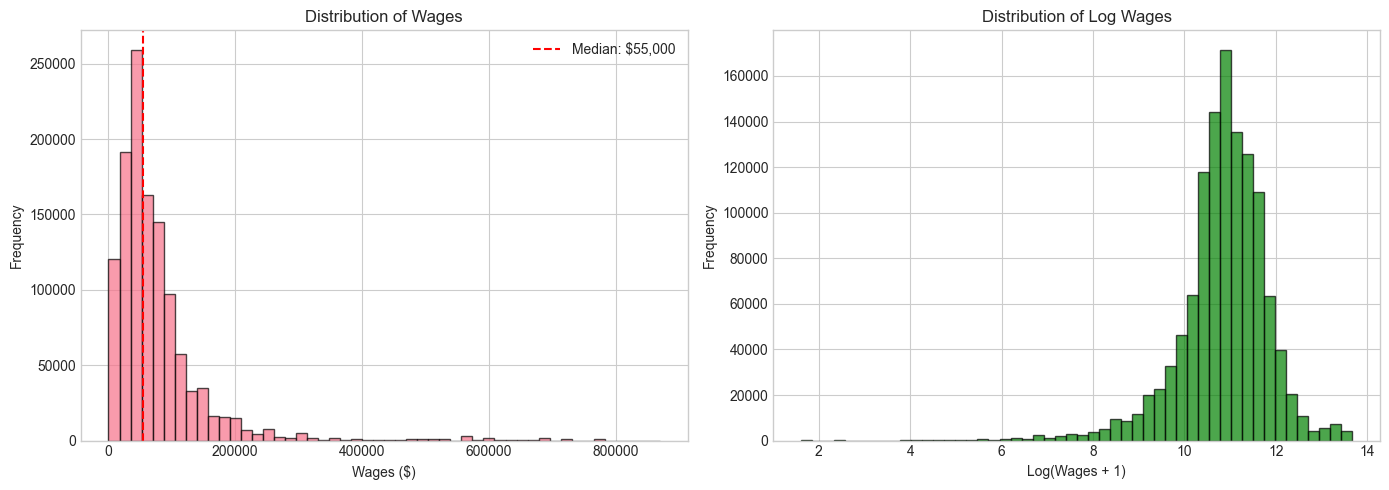

In [5]:
# Distribution of wages
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw wages
axes[0].hist(df_workers['wagp'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Wages ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Wages')
axes[0].axvline(df_workers['wagp'].median(), color='red', linestyle='--', label=f'Median: ${df_workers["wagp"].median():,.0f}')
axes[0].legend()

# Log wages
df_workers['log_wagp'] = np.log1p(df_workers['wagp'])
axes[1].hist(df_workers['log_wagp'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Wages + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Log Wages')

plt.tight_layout()
plt.show()

### 2.2 Feature Engineering

In [6]:
# Education years mapping (approximate)
EDUCATION_YEARS = {
    1: 0, 2: 0, 3: 0,           # No schooling / preschool / kindergarten
    4: 1, 5: 2, 6: 3, 7: 4,     # Grades 1-4
    8: 5, 9: 6, 10: 7, 11: 8,   # Grades 5-8
    12: 9, 13: 10, 14: 11, 15: 11,  # Grades 9-12 (no diploma)
    16: 12, 17: 12,             # High school diploma / GED
    18: 13, 19: 14,             # Some college
    20: 14,                     # Associate's
    21: 16,                     # Bachelor's
    22: 18,                     # Master's
    23: 20,                     # Professional
    24: 21                      # Doctorate
}

# Create derived features
df_workers['education_years'] = df_workers['schl'].map(EDUCATION_YEARS)
df_workers['education_category'] = df_workers['schl'].apply(get_education_category)

# Experience = Age - Education Years - 6 (school start age)
df_workers['experience'] = df_workers['agep'] - df_workers['education_years'] - 6
df_workers['experience'] = df_workers['experience'].clip(lower=0)  # No negative experience

# Experience squared (for diminishing returns)
df_workers['experience_sq'] = df_workers['experience'] ** 2

# Age squared
df_workers['age_sq'] = df_workers['agep'] ** 2

# Sex as binary
df_workers['is_female'] = (df_workers['sex'] == 2).astype(int)

# Occupation category (first 2 digits of OCCP for major group)
df_workers['occp_major'] = df_workers['occp'].astype(str).str[:2]

# Industry category (first 2 digits of INDP for major sector)
df_workers['indp_major'] = df_workers['indp'].astype(str).str[:2]

print("Feature engineering complete!")
print(f"\nNew features: education_years, education_category, experience, experience_sq, age_sq, is_female, occp_major, indp_major")

Feature engineering complete!

New features: education_years, education_category, experience, experience_sq, age_sq, is_female, occp_major, indp_major


In [7]:
# Check for missing values in key features
key_features = ['agep', 'sex', 'schl', 'wkhp', 'st', 'occp', 'indp', 'cow', 'education_years', 'experience']
missing_summary = df_workers[key_features].isnull().sum()
print("Missing values in key features:")
print(missing_summary[missing_summary > 0])
print(f"\nTotal records: {len(df_workers):,}")

Missing values in key features:
Series([], dtype: int64)

Total records: 1,198,252


### 2.3 Prepare Final Dataset

In [8]:
# Select features for modeling
# Numeric features
numeric_features = [
    'agep',           # Age
    'experience',     # Derived experience
    'experience_sq',  # Experience squared
    'wkhp',           # Hours worked per week
    'education_years' # Years of education
]

# Categorical features
categorical_features = [
    'sex',              # Sex (1=Male, 2=Female)
    'education_category', # Education level
    'st',               # State
    'cow',              # Class of worker
    'occp_major',       # Occupation major group
    'indp_major'        # Industry major sector
]

# Target variable
target = 'log_wagp'  # Using log wages for better distribution

# Create modeling dataset
all_features = numeric_features + categorical_features
df_model = df_workers[all_features + [target, 'wagp', 'pwgtp']].dropna()

print(f"Modeling dataset: {len(df_model):,} records")
print(f"Features: {len(all_features)}")

Modeling dataset: 1,198,252 records
Features: 11


In [9]:
# Summary of categorical features
print("Categorical Feature Cardinality:")
for feat in categorical_features:
    print(f"  {feat}: {df_model[feat].nunique()} unique values")

Categorical Feature Cardinality:
  sex: 2 unique values
  education_category: 8 unique values
  st: 51 unique values
  cow: 8 unique values
  occp_major: 99 unique values
  indp_major: 94 unique values


## 3. Exploratory Data Analysis

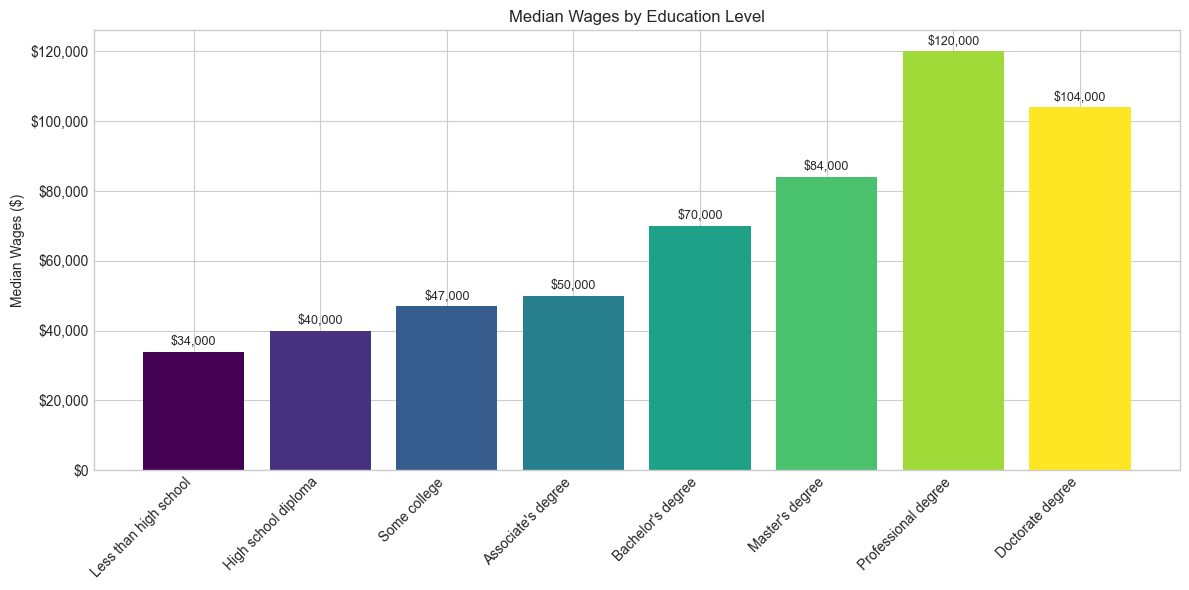

In [10]:
# Wage by education level
edu_order = ['Less than high school', 'High school diploma', 'Some college', 
             "Associate's degree", "Bachelor's degree", "Master's degree", 
             'Professional degree', 'Doctorate degree']

fig, ax = plt.subplots(figsize=(12, 6))
edu_wages = df_model.groupby('education_category')['wagp'].median().reindex(edu_order)
bars = ax.bar(range(len(edu_wages)), edu_wages.values, color=plt.cm.viridis(np.linspace(0, 1, len(edu_wages))))
ax.set_xticks(range(len(edu_wages)))
ax.set_xticklabels(edu_wages.index, rotation=45, ha='right')
ax.set_ylabel('Median Wages ($)')
ax.set_title('Median Wages by Education Level')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Add value labels
for bar, val in zip(bars, edu_wages.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
            f'${val:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

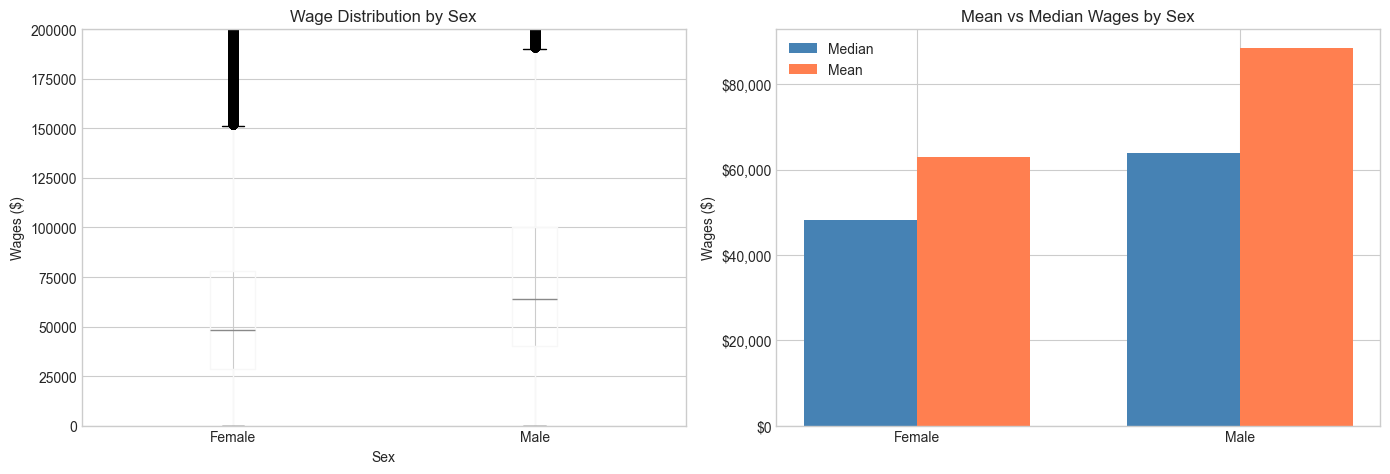


Gender Wage Gap: 24.8% (Female median is 75.2% of Male median)


In [11]:
# Wage by sex
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
sex_labels = {1: 'Male', 2: 'Female'}
df_model['sex_label'] = df_model['sex'].map(sex_labels)
df_model.boxplot(column='wagp', by='sex_label', ax=axes[0])
axes[0].set_title('Wage Distribution by Sex')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Wages ($)')
axes[0].set_ylim(0, 200000)
plt.suptitle('')

# Median comparison
sex_wages = df_model.groupby('sex_label')['wagp'].agg(['median', 'mean'])
x = range(len(sex_wages))
width = 0.35
axes[1].bar([i - width/2 for i in x], sex_wages['median'], width, label='Median', color='steelblue')
axes[1].bar([i + width/2 for i in x], sex_wages['mean'], width, label='Mean', color='coral')
axes[1].set_xticks(x)
axes[1].set_xticklabels(sex_wages.index)
axes[1].set_ylabel('Wages ($)')
axes[1].set_title('Mean vs Median Wages by Sex')
axes[1].legend()
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# Gender wage gap
male_median = sex_wages.loc['Male', 'median']
female_median = sex_wages.loc['Female', 'median']
gap = (male_median - female_median) / male_median * 100
print(f"\nGender Wage Gap: {gap:.1f}% (Female median is {100-gap:.1f}% of Male median)")

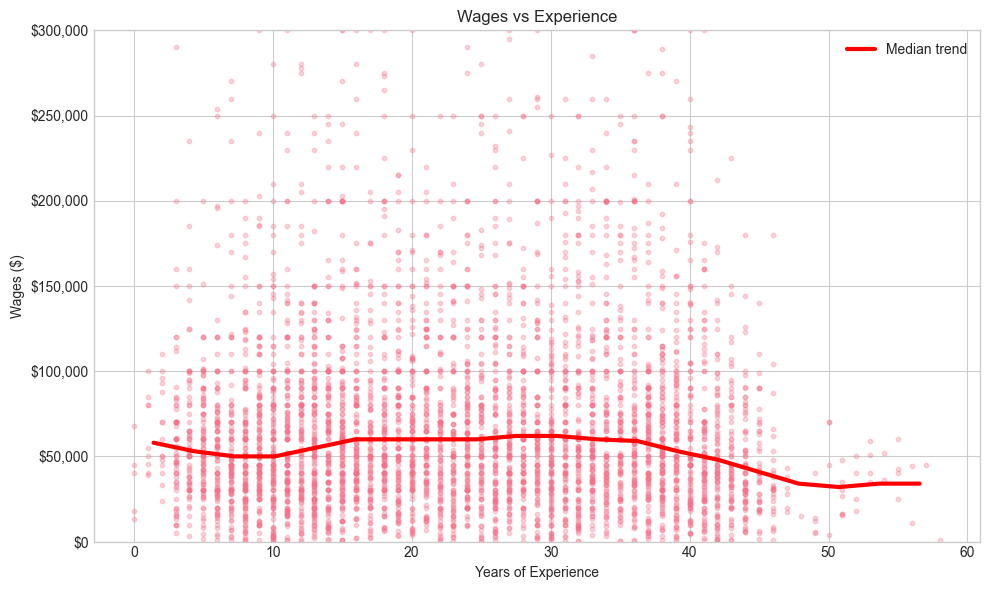

In [12]:
# Wage vs Experience
fig, ax = plt.subplots(figsize=(10, 6))

# Sample for visualization
sample = df_model.sample(min(5000, len(df_model)), random_state=42)
ax.scatter(sample['experience'], sample['wagp'], alpha=0.3, s=10)

# Add trend line
exp_bins = pd.cut(df_model['experience'], bins=20)
exp_median = df_model.groupby(exp_bins)['wagp'].median()
exp_centers = [(interval.left + interval.right) / 2 for interval in exp_median.index]
ax.plot(exp_centers, exp_median.values, 'r-', linewidth=3, label='Median trend')

ax.set_xlabel('Years of Experience')
ax.set_ylabel('Wages ($)')
ax.set_title('Wages vs Experience')
ax.set_ylim(0, 300000)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax.legend()

plt.tight_layout()
plt.show()

## 4. Model Training

In [13]:
# Prepare features and target
X = df_model[all_features].copy()
y = df_model[target].copy()
sample_weights = df_model['pwgtp'].copy()  # Person weights

# Convert categorical features to string type
for col in categorical_features:
    X[col] = X[col].astype(str)

# Split data
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

Training set: 958,601 samples
Test set: 239,651 samples


In [14]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Fit preprocessor and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed feature dimensions: {X_train_processed.shape[1]}")

Processed feature dimensions: 267


In [ ]:
# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Train and evaluate models
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train
    if hasattr(model, 'sample_weight'):
        model.fit(X_train_processed, y_train, sample_weight=w_train)
    else:
        model.fit(X_train_processed, y_train)
    
    # Predict
    y_pred = model.predict(X_test_processed)
    
    # Convert back from log scale for interpretable metrics
    y_test_actual = np.expm1(y_test)
    y_pred_actual = np.expm1(y_pred)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_test, y_pred)  # R2 on log scale
    
    results.append({
        'Model': name,
        'RMSE ($)': rmse,
        'MAE ($)': mae,
        'R² (log scale)': r2
    })
    
    print(f"  RMSE: ${rmse:,.0f}, MAE: ${mae:,.0f}, R²: {r2:.4f}")

results_df = pd.DataFrame(results)
print("\n" + "="*60)
print(results_df.to_string(index=False))

Training Linear Regression...
  RMSE: $70,600, MAE: $33,756, R²: 0.4552
Training Ridge Regression...
  RMSE: $70,602, MAE: $33,757, R²: 0.4552
Training Lasso Regression...
  RMSE: $77,171, MAE: $38,073, R²: 0.3474
Training Random Forest...


In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R² comparison
axes[0].barh(results_df['Model'], results_df['R² (log scale)'], color='steelblue')
axes[0].set_xlabel('R² Score')
axes[0].set_title('Model Comparison: R² (higher is better)')
axes[0].set_xlim(0, 1)

# RMSE comparison
axes[1].barh(results_df['Model'], results_df['RMSE ($)'], color='coral')
axes[1].set_xlabel('RMSE ($)')
axes[1].set_title('Model Comparison: RMSE (lower is better)')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# MAE comparison
axes[2].barh(results_df['Model'], results_df['MAE ($)'], color='green')
axes[2].set_xlabel('MAE ($)')
axes[2].set_title('Model Comparison: MAE (lower is better)')
axes[2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

## 5. Feature Importance Analysis

In [ ]:
# Get feature names after preprocessing
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numeric_features) + list(cat_feature_names)

# Use Random Forest for feature importance
rf_model = models['Random Forest']
importances = rf_model.feature_importances_

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Show top 20 features
print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

In [ ]:
# Visualize top features
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 20
top_features = importance_df.head(top_n)

ax.barh(range(top_n), top_features['Importance'].values, color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title(f'Top {top_n} Feature Importances (Random Forest)')

plt.tight_layout()
plt.show()

In [ ]:
# Aggregate importance by feature category
category_importance = {}

# Numeric features
for feat in numeric_features:
    idx = all_feature_names.index(feat)
    category_importance[feat] = importances[idx]

# Categorical features (sum of all one-hot encoded columns)
for cat_feat in categorical_features:
    total_imp = sum(importances[i] for i, name in enumerate(all_feature_names) if name.startswith(cat_feat + '_'))
    category_importance[cat_feat] = total_imp

# Sort and display
cat_imp_df = pd.DataFrame([
    {'Feature Category': k, 'Total Importance': v} 
    for k, v in category_importance.items()
]).sort_values('Total Importance', ascending=False)

print("\nFeature Category Importance:")
print(cat_imp_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(cat_imp_df['Feature Category'], cat_imp_df['Total Importance'], color='teal')
ax.set_xlabel('Total Importance')
ax.set_title('Feature Category Importance')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Model Predictions Analysis

In [ ]:
# Use best model (Gradient Boosting or Random Forest based on results)
best_model = models['Gradient Boosting']
y_pred = best_model.predict(X_test_processed)

# Convert back from log scale
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

# Actual vs Predicted plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
sample_idx = np.random.choice(len(y_test_actual), min(5000, len(y_test_actual)), replace=False)
axes[0].scatter(y_test_actual.iloc[sample_idx], y_pred_actual[sample_idx], alpha=0.3, s=10)
axes[0].plot([0, 300000], [0, 300000], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Wages ($)')
axes[0].set_ylabel('Predicted Wages ($)')
axes[0].set_title('Actual vs Predicted Wages')
axes[0].set_xlim(0, 300000)
axes[0].set_ylim(0, 300000)
axes[0].legend()

# Residuals distribution
residuals = y_test_actual - y_pred_actual
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', label='Zero error')
axes[1].set_xlabel('Residual (Actual - Predicted) ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Prediction Errors')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nMean Residual: ${residuals.mean():,.0f}")
print(f"Median Residual: ${residuals.median():,.0f}")
print(f"Std of Residuals: ${residuals.std():,.0f}")

## 7. Wage Predictions by Demographic Groups

In [ ]:
# Create test dataframe with predictions
test_results = X_test.copy()
test_results['actual_wage'] = y_test_actual.values
test_results['predicted_wage'] = y_pred_actual
test_results['residual'] = test_results['actual_wage'] - test_results['predicted_wage']

# Analyze by education
edu_analysis = test_results.groupby('education_category').agg({
    'actual_wage': ['mean', 'median'],
    'predicted_wage': ['mean', 'median'],
    'residual': 'mean'
}).round(0)

edu_analysis.columns = ['Actual Mean', 'Actual Median', 'Predicted Mean', 'Predicted Median', 'Mean Error']
edu_analysis = edu_analysis.reindex(edu_order)

print("Wage Predictions by Education Level:")
print(edu_analysis.to_string())

In [ ]:
# Analyze by sex
sex_analysis = test_results.groupby('sex').agg({
    'actual_wage': ['mean', 'median'],
    'predicted_wage': ['mean', 'median'],
    'residual': 'mean'
}).round(0)

sex_analysis.columns = ['Actual Mean', 'Actual Median', 'Predicted Mean', 'Predicted Median', 'Mean Error']
sex_analysis.index = sex_analysis.index.map(lambda x: 'Male' if x == '1' else 'Female')

print("\nWage Predictions by Sex:")
print(sex_analysis.to_string())

## 8. Save Model and Summary

In [ ]:
import joblib

# Save the best model and preprocessor
model_dir = Path.cwd().parent / 'models'
model_dir.mkdir(exist_ok=True)

joblib.dump(best_model, model_dir / 'wage_prediction_model.joblib')
joblib.dump(preprocessor, model_dir / 'wage_preprocessor.joblib')

print(f"Model saved to {model_dir / 'wage_prediction_model.joblib'}")
print(f"Preprocessor saved to {model_dir / 'wage_preprocessor.joblib'}")

In [ ]:
# Summary statistics
print("="*60)
print("WAGE PREDICTION MODEL SUMMARY")
print("="*60)
print(f"\nDataset: PUMS 2023 Person-level data")
print(f"Sample size: {len(df_model):,} workers (age 25-64, positive wages)")
print(f"\nFeatures used: {len(all_features)}")
print(f"  - Numeric: {numeric_features}")
print(f"  - Categorical: {categorical_features}")
print(f"\nBest Model: Gradient Boosting Regressor")
print(f"  - R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"  - RMSE: ${np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)):,.0f}")
print(f"  - MAE: ${mean_absolute_error(y_test_actual, y_pred_actual):,.0f}")
print(f"\nTop 5 Important Features:")
for i, row in cat_imp_df.head(5).iterrows():
    print(f"  {row['Feature Category']}: {row['Total Importance']:.4f}")

## 9. Example Predictions

In [ ]:
def predict_wage(age, sex, education_category, state, cow, occp_major, indp_major, wkhp, education_years=None):
    """
    Predict wage for a given set of characteristics.
    
    Parameters:
    - age: Age in years
    - sex: 1 for Male, 2 for Female
    - education_category: e.g., "Bachelor's degree"
    - state: State code (e.g., '06' for California)
    - cow: Class of worker (1-9)
    - occp_major: Occupation major group (2-digit code)
    - indp_major: Industry major sector (2-digit code)
    - wkhp: Hours worked per week
    - education_years: Years of education (optional, will be estimated)
    """
    # Estimate education years if not provided
    edu_years_map = {
        'Less than high school': 10,
        'High school diploma': 12,
        'Some college': 14,
        "Associate's degree": 14,
        "Bachelor's degree": 16,
        "Master's degree": 18,
        'Professional degree': 20,
        'Doctorate degree': 21
    }
    
    if education_years is None:
        education_years = edu_years_map.get(education_category, 12)
    
    experience = max(0, age - education_years - 6)
    
    # Create input dataframe
    input_data = pd.DataFrame([{
        'agep': age,
        'experience': experience,
        'experience_sq': experience ** 2,
        'wkhp': wkhp,
        'education_years': education_years,
        'sex': str(sex),
        'education_category': education_category,
        'st': str(state),
        'cow': str(cow),
        'occp_major': str(occp_major),
        'indp_major': str(indp_major)
    }])
    
    # Preprocess and predict
    input_processed = preprocessor.transform(input_data)
    log_wage_pred = best_model.predict(input_processed)[0]
    wage_pred = np.expm1(log_wage_pred)
    
    return wage_pred

# Example predictions
print("Example Wage Predictions:")
print("="*60)

# Example 1: Young male with bachelor's degree in tech
pred1 = predict_wage(age=30, sex=1, education_category="Bachelor's degree", 
                     state='06', cow=1, occp_major='15', indp_major='51', wkhp=40)
print(f"\n30-year-old male, Bachelor's degree, Tech industry (CA):")
print(f"  Predicted annual wage: ${pred1:,.0f}")

# Example 2: Female with master's degree in healthcare
pred2 = predict_wage(age=40, sex=2, education_category="Master's degree", 
                     state='36', cow=2, occp_major='29', indp_major='62', wkhp=40)
print(f"\n40-year-old female, Master's degree, Healthcare (NY):")
print(f"  Predicted annual wage: ${pred2:,.0f}")

# Example 3: High school graduate in manufacturing
pred3 = predict_wage(age=35, sex=1, education_category="High school diploma", 
                     state='48', cow=1, occp_major='51', indp_major='33', wkhp=45)
print(f"\n35-year-old male, High school diploma, Manufacturing (TX):")
print(f"  Predicted annual wage: ${pred3:,.0f}")